In [4]:
from helpers import generate_classification_data, evaluate_classification_metrics, FeatureNormalizer
from PyTorch_models import BaseClassifier, TorchTrainer

from torch.utils.data import TensorDataset, DataLoader
import torch

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [5]:
# get data

num_features = 5

# Data without noise (ground truth)
df_clean = generate_classification_data(
    num_samples=5000,
    num_features=num_features,
    aleatoric_strength=0.0,  # No noise
    sparse_region=False
)

features = [c for c in df_clean.columns if c not in ["y", "prob"]]
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(df_clean[features], df_clean["y"], test_size=0.33, random_state=42)

# Data with aleatoric noise
df_noisy = generate_classification_data(
    num_samples=5000,
    num_features=num_features,
    aleatoric_strength=2.0,  # Strong noise for clarity
    sparse_region=False
)

features = [c for c in df_noisy.columns if c not in ["y", "prob"]]
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(df_noisy[features], df_noisy["y"], test_size=0.33, random_state=42)



In [ ]:
# Instantiate and fit transformer

normalizer = FeatureNormalizer()
normalizer.fit(X_train_clean, features)


In [6]:

def get_loader(X, y, features, normalizer, batch_size=128):
    X_tr = normalizer.transform(X)
    X_torch = torch.tensor(X_tr.values, dtype=torch.float32)
    y_torch = torch.tensor(y.values, dtype=torch.float32)
    return DataLoader(TensorDataset(X_torch, y_torch), batch_size=batch_size)

train_loader_clean = get_loader(X_train_clean, y_train_clean, features, normalizer)
test_loader_clean = get_loader(X_test_clean, y_test_clean, features, normalizer)

train_loader_noisy = get_loader(X_train_noisy, y_train_noisy, features, normalizer)
test_loader_noisy = get_loader(X_test_noisy, y_test_noisy, features, normalizer)

In [20]:

model_clean = BaseClassifier(input_dim=num_features, hidden_dims=[128, 64], output_type="beta")
trainer_clean = TorchTrainer(model_clean, lr=1e-2, epochs=30)
trainer_clean.train(train_loader_clean)

Epoch 1/30 - Train loss: 0.5279
Epoch 2/30 - Train loss: 0.4855
Epoch 3/30 - Train loss: 0.4814
Epoch 4/30 - Train loss: 0.4779
Epoch 5/30 - Train loss: 0.4747
Epoch 6/30 - Train loss: 0.4728
Epoch 7/30 - Train loss: 0.4703
Epoch 8/30 - Train loss: 0.4679
Epoch 9/30 - Train loss: 0.4659
Epoch 10/30 - Train loss: 0.4633
Epoch 11/30 - Train loss: 0.4605
Epoch 12/30 - Train loss: 0.4580
Epoch 13/30 - Train loss: 0.4551
Epoch 14/30 - Train loss: 0.4526
Epoch 15/30 - Train loss: 0.4506
Epoch 16/30 - Train loss: 0.4474
Epoch 17/30 - Train loss: 0.4443
Epoch 18/30 - Train loss: 0.4409
Epoch 19/30 - Train loss: 0.4386
Epoch 20/30 - Train loss: 0.4350
Epoch 21/30 - Train loss: 0.4327
Epoch 22/30 - Train loss: 0.4313
Epoch 23/30 - Train loss: 0.4286
Epoch 24/30 - Train loss: 0.4269
Epoch 25/30 - Train loss: 0.4237
Epoch 26/30 - Train loss: 0.4236
Epoch 27/30 - Train loss: 0.4185
Epoch 28/30 - Train loss: 0.4159
Epoch 29/30 - Train loss: 0.4113
Epoch 30/30 - Train loss: 0.4094


In [11]:
# check classification  score

# Get predictions
probs = trainer_clean.predict_proba(test_loader_clean)

# Ground truth labels
y_true = y_test_clean.copy()

# Compute metrics
metrics = evaluate_classification_metrics(y_true, probs)

# Print results
print()
print("Score on clean test data")
for k, v in metrics.items():
    if k != "Confusion Matrix":
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}:\n{v}")


Score on clean test data
Accuracy: 0.7715
Precision: 0.7721
Recall: 0.8443
F1 Score: 0.8066
ROC AUC: 0.8347
Brier Score: 0.1597
Confusion Matrix:
[[487 232]
 [145 786]]


In [13]:
mean_probs_clean, std_unc_clean = trainer_clean.predict_proba_with_uncertainty(test_loader_noisy)
x2_noisy = X_test_noisy["x2"].values
y_true_noisy = y_test_noisy.values


In [14]:
model_noisy = BaseClassifier(input_dim=num_features, hidden_dims=[128, 64], output_type="beta")
trainer_noisy = TorchTrainer(model_noisy, lr=1e-3, epochs=30)
trainer_noisy.train(train_loader_noisy)
mean_probs_noisy, std_unc_noisy = trainer_noisy.predict_proba_with_uncertainty(test_loader_noisy)


Epoch 1/30 - Train loss: 0.6658
Epoch 2/30 - Train loss: 0.6285
Epoch 3/30 - Train loss: 0.6199
Epoch 4/30 - Train loss: 0.6153
Epoch 5/30 - Train loss: 0.6128
Epoch 6/30 - Train loss: 0.6112
Epoch 7/30 - Train loss: 0.6101
Epoch 8/30 - Train loss: 0.6090
Epoch 9/30 - Train loss: 0.6080
Epoch 10/30 - Train loss: 0.6071
Epoch 11/30 - Train loss: 0.6063
Epoch 12/30 - Train loss: 0.6054
Epoch 13/30 - Train loss: 0.6046
Epoch 14/30 - Train loss: 0.6037
Epoch 15/30 - Train loss: 0.6029
Epoch 16/30 - Train loss: 0.6020
Epoch 17/30 - Train loss: 0.6011
Epoch 18/30 - Train loss: 0.6002
Epoch 19/30 - Train loss: 0.5993
Epoch 20/30 - Train loss: 0.5983
Epoch 21/30 - Train loss: 0.5974
Epoch 22/30 - Train loss: 0.5964
Epoch 23/30 - Train loss: 0.5955
Epoch 24/30 - Train loss: 0.5946
Epoch 25/30 - Train loss: 0.5936
Epoch 26/30 - Train loss: 0.5927
Epoch 27/30 - Train loss: 0.5916
Epoch 28/30 - Train loss: 0.5908
Epoch 29/30 - Train loss: 0.5898
Epoch 30/30 - Train loss: 0.5889


In [16]:
# check classification  score

# Get predictions
probs = trainer_noisy.predict_proba(test_loader_noisy)

# Ground truth labels
y_true = y_test_noisy.copy()

# Compute metrics
metrics = evaluate_classification_metrics(y_true, probs)

# Print results
print()
print("Score on noisy test data")
for k, v in metrics.items():
    if k != "Confusion Matrix":
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}:\n{v}")


Score on noisy test data
Accuracy: 0.6285
Precision: 0.5972
Recall: 0.7413
F1 Score: 0.6615
ROC AUC: 0.6750
Brier Score: 0.2209
Confusion Matrix:
[[438 404]
 [209 599]]


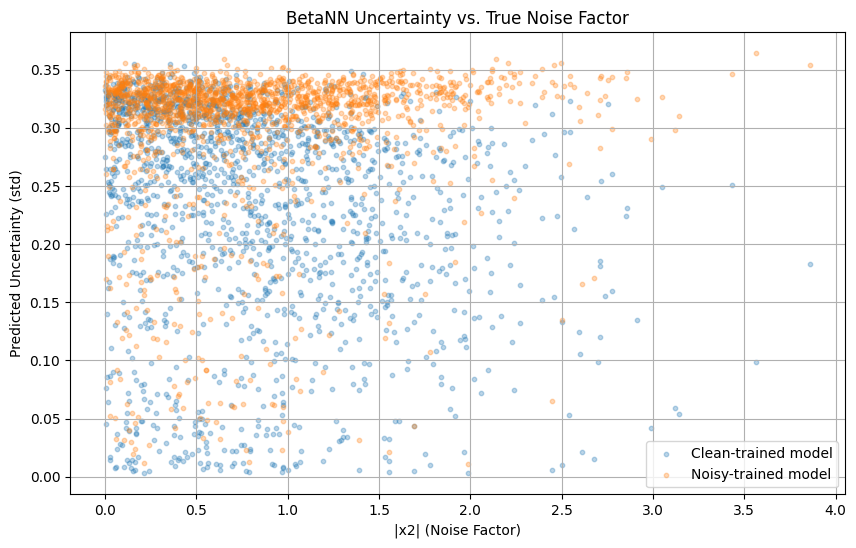

In [17]:

plt.figure(figsize=(10, 6))
plt.scatter(np.abs(x2_noisy), std_unc_clean, alpha=0.3, label="Clean-trained model", s=10)
plt.scatter(np.abs(x2_noisy), std_unc_noisy, alpha=0.3, label="Noisy-trained model", s=10)
plt.xlabel("|x2| (Noise Factor)")
plt.ylabel("Predicted Uncertainty (std)")
plt.title("BetaNN Uncertainty vs. True Noise Factor")
plt.legend()
plt.grid(True)
plt.show()



In [18]:
from scipy.stats import spearmanr

corr_clean = spearmanr(np.abs(x2_noisy), std_unc_clean)[0]
corr_noisy = spearmanr(np.abs(x2_noisy), std_unc_noisy)[0]
print(f"Spearman Correlation (Clean-trained): {corr_clean:.3f}")
print(f"Spearman Correlation (Noisy-trained): {corr_noisy:.3f}")


Spearman Correlation (Clean-trained): -0.274
Spearman Correlation (Noisy-trained): 0.101


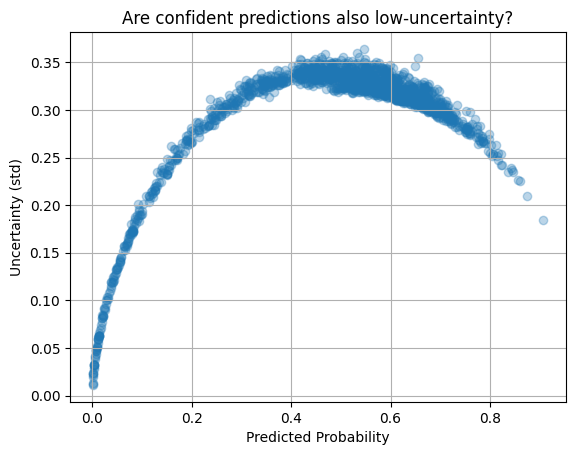

In [19]:
plt.scatter(mean_probs_noisy, std_unc_noisy, alpha=0.3)
plt.xlabel("Predicted Probability")
plt.ylabel("Uncertainty (std)")
plt.title("Are confident predictions also low-uncertainty?")
plt.grid(True)
plt.show()
